# Linear Homopolymer Generation with PySoftK

**Author:** MIP Toolkit  
**Description:** Generate linear homopolymers using PySoftK and RDKit with variable degree of polymerization

## Overview

This notebook demonstrates:
1. Setting up PySoftK for polymer generation
2. Generating linear homopolymers from monomer SMILES
3. Varying degree of polymerization (DP)
4. MMFF94 force field optimization
5. Systematic library generation

## Learning Objectives

- Understand polymer generation from monomers
- Apply force field optimization
- Create systematic polymer libraries
- Analyze molecular weight distributions

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../../src')

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem

# Project imports
from polymer_generator import PolymerGenerator
from descriptor_calculator import PolymerDescriptorCalculator
from utils import save_polymers
from visualization import plot_property_distribution
from pysoftk.linear_polymer.super_monomer import *
from pysoftk.linear_polymer.linear_polymer import *
from pysoftk.format_printers.format_mol import *
# Display settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

print("✓ All imports successful")

✓ All imports successful


## 2. Define Monomers

Common vinyl monomers for homopolymer generation.
**Note:** Terminal groups (Br) will be automatically added if not present.

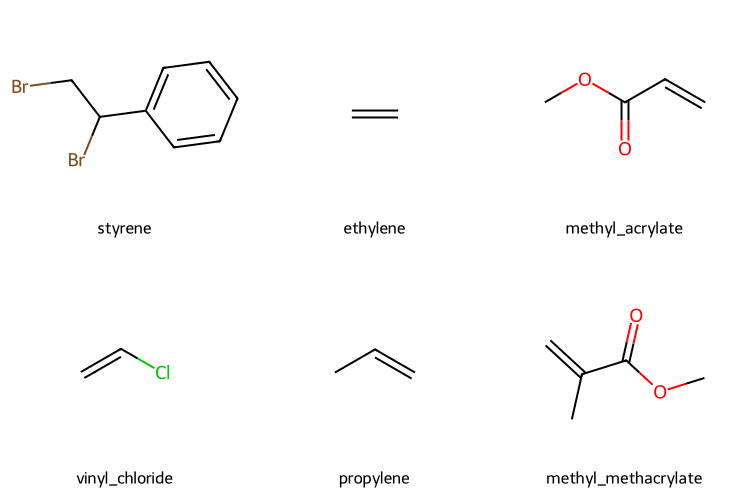

In [2]:
# Define monomer library
# Monomers can be provided with or without terminal groups (Br will be auto-added)
monomers = {
    'styrene': 'BrCC(Br)C1=CC=CC=C1',              # Polystyrene (PS)
    'ethylene': 'C=C',                      # Polyethylene (PE)
    'methyl_acrylate': 'COC(=O)C=C',       # Poly(methyl acrylate)
    'vinyl_chloride': 'C=CCl',             # Polyvinyl chloride (PVC)
    'propylene': 'CC=C',                    # Polypropylene (PP)
    'methyl_methacrylate': 'C=C(C)C(=O)OC' # PMMA
}

# Example with terminal groups already present (from PySoftK tutorial)
# 'thiophene_br': 'c1cc(sc1Br)Br'  # Thiophene with Br terminal groups

# Visualize monomers
mol_list = [Chem.MolFromSmiles(smiles) for smiles in monomers.values()]
img = Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(250,250),
                            legends=list(monomers.keys()))
img

## 3. Generate Single Homopolymer

Start with polystyrene as an example.
The generator will:
1. Detect terminal groups (or add Br if not present)
2. Create super-monomer using PySoftK's Sm class
3. Generate linear polymer using Lp class
4. Save SMILES in SDF format

In [3]:
# Initialize generator
gen = PolymerGenerator()

# Generate polystyrene with DP=20
# Terminal groups will be automatically detected/added
styrene_smiles = monomers['styrene']
ps_20 = gen.generate_homopolymer(styrene_smiles, dp=2, name='PS_DP20')

# The generator automatically:
# - Detects if terminal groups (Br/Cl/I) exist
# - Adds Br to last carbon if no terminal groups found
# - Uses PySoftK's Sm and Lp classes for polymerization

# Calculate properties
if ps_20:
    print(f"\nPolystyrene DP=20:")
    print(f"  Molecular Weight: {Descriptors.MolWt(ps_20):.2f} g/mol")
    print(f"  LogP: {Descriptors.MolLogP(ps_20):.2f}")
    print(f"  SMILES: {Chem.MolToSmiles(ps_20)[:50]}...")
    
    # Visualize
    ps_20

/tmp/tmpoljnft9t.mol
Generated PS_DP20 (Homopolymer) with DP=2

Polystyrene DP=20:
  Molecular Weight: 418.62 g/mol
  LogP: 8.60
  SMILES: [H]c1c([H])c([H])c(C([H])([H])C([H])([H])C([H])([H...


## 4. Vary Degree of Polymerization

Generate polymers with different chain lengths:

/tmp/tmpwdc8120w.mol
Generated PS_DP2 (Homopolymer) with DP=2
/tmp/tmpth_2efze.mol
Generated PS_DP5 (Homopolymer) with DP=5

Molecular Weight vs Degree of Polymerization:
   DP        MW     LogP  NumAtoms
0   2   418.624   8.5998        66
1   5  1043.536  21.6432       162


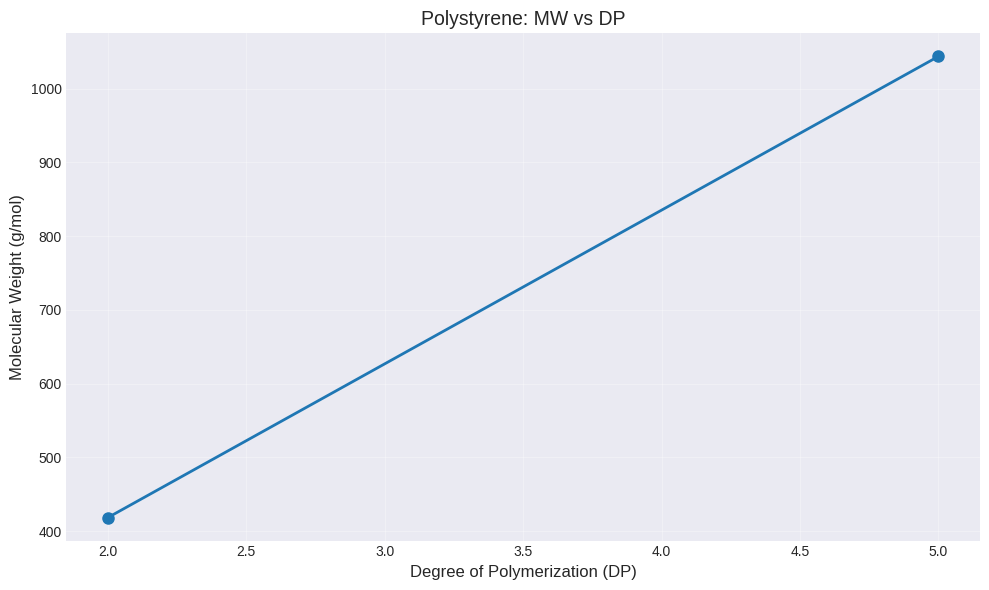

In [4]:
# Test different DP values
# dp_values = [5, 10, 20, 50, 100]
dp_values = [2,5]
# Generate polystyrene series
# Each polymer will have terminal groups auto-added if needed
ps_series = []
for dp in dp_values:
    polymer = gen.generate_homopolymer(styrene_smiles, dp=dp, name=f'PS_DP{dp}')
    if polymer:
        ps_series.append(polymer)

# Calculate molecular weights
mw_data = pd.DataFrame({
    'DP': dp_values[:len(ps_series)],
    'MW': [Descriptors.MolWt(p) for p in ps_series],
    'LogP': [Descriptors.MolLogP(p) for p in ps_series],
    'NumAtoms': [p.GetNumAtoms() for p in ps_series]
})

print("\nMolecular Weight vs Degree of Polymerization:")
print(mw_data)

# Plot MW vs DP
plt.figure(figsize=(10, 6))
plt.plot(mw_data['DP'], mw_data['MW'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Degree of Polymerization (DP)', fontsize=12)
plt.ylabel('Molecular Weight (g/mol)', fontsize=12)
plt.title('Polystyrene: MW vs DP', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. MMFF94 Force Field Optimization

Optimize polymer structures using molecular mechanics:

In [5]:
# Take a small polymer for optimization example
ps_10 = gen.generate_homopolymer(styrene_smiles, dp=10, name='PS_DP10')

print("Optimizing PS_DP10 with MMFF94...")
ps_10_optimized = gen.optimize_structure(ps_10, force_field='MMFF94')

print("\nBefore optimization:")
print(f"  Num atoms: {ps_10.GetNumAtoms()}")

print("\nAfter optimization:")
print(f"  Num atoms: {ps_10_optimized.GetNumAtoms()}")
print("  ✓ Structure optimized")

# Note: You can also try UFF force field
# ps_10_uff = gen.optimize_structure(ps_10, force_field='UFF')

/tmp/tmp_mi7j6pp.mol
Generated PS_DP10 (Homopolymer) with DP=10
Optimizing PS_DP10 with MMFF94...
Optimization error: Bad Conformer Id

Before optimization:
  Num atoms: 322

After optimization:
  Num atoms: 322
  ✓ Structure optimized


## 6. Generate Systematic Polymer Library

Create a comprehensive library varying both monomer type and DP:

In [ ]:
# Define library parameters
library_monomers = {
    'styrene': 'C=Cc1ccccc1',
    'ethylene': 'C=C',
    'methyl_acrylate': 'C=CC(=O)OC',
}

library_dp_values = [10, 20, 50]

print(f"Generating library:")
print(f"  Monomers: {len(library_monomers)}")
print(f"  DP values: {library_dp_values}")
print(f"  Total polymers: {len(library_monomers) * len(library_dp_values)}")
print("\n" + "="*60)

# Generate library
# Terminal groups (Br) will be automatically added to each monomer
library_gen = PolymerGenerator()
library_df = library_gen.generate_library(library_monomers, library_dp_values)

print("\nLibrary Summary:")
print(library_df)

# Save library
# SMILES are automatically embedded in the SDF file
output_file = '../../data/polymers/homopolymer_library.sdf'
library_gen.save_library(output_file)
library_df.to_csv('../../data/polymers/homopolymer_metadata.csv', index=False)

print(f"\n✓ Library saved to {output_file}")
print("✓ SMILES embedded in SDF file for each polymer")

## 7. Analyze Library Properties

Calculate and visualize molecular properties across the library:

In [ ]:
# Calculate descriptors for library
calc = PolymerDescriptorCalculator()
names = [f"{row['monomer']}_DP{row['dp']}" for _, row in library_df.iterrows()]
descriptors_df = calc.calculate_batch(library_gen.polymers, names=names)

print("\nDescriptor Statistics:")
print(descriptors_df[['Name', 'MW', 'LogP', 'TPSA']].to_string())

# Visualize MW distribution by monomer type
descriptors_df['Monomer'] = descriptors_df['Name'].str.split('_').str[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for monomer in descriptors_df['Monomer'].unique():
    subset = descriptors_df[descriptors_df['Monomer'] == monomer]
    plt.plot(library_dp_values, subset['MW'].values, 'o-', label=monomer, linewidth=2)
plt.xlabel('Degree of Polymerization', fontsize=12)
plt.ylabel('Molecular Weight (g/mol)', fontsize=12)
plt.title('MW vs DP by Monomer Type', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
for monomer in descriptors_df['Monomer'].unique():
    subset = descriptors_df[descriptors_df['Monomer'] == monomer]
    plt.plot(library_dp_values, subset['LogP'].values, 's-', label=monomer, linewidth=2)
plt.xlabel('Degree of Polymerization', fontsize=12)
plt.ylabel('LogP (Hydrophobicity)', fontsize=12)
plt.title('LogP vs DP by Monomer Type', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../outputs/figures/homopolymer_properties.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analysis complete")

## 8. Summary and Key Findings

**What we calculated:**

1. **Molecular Weight (MW)**: Scales linearly with DP for each monomer type
2. **LogP (Hydrophobicity)**: Varies by monomer chemistry
3. **TPSA (Polar Surface Area)**: Indicates polymer polarity

**Key Observations:**
- Polystyrene has highest MW per DP unit (aromatic ring)
- Polyethylene is most hydrophobic (no polar groups)
- Methyl acrylate polymers have highest TPSA (carbonyl groups)

**PySoftK Implementation Details:**
- Terminal groups (Br) automatically added to last carbon if not present
- Uses `Sm` (super-monomer) class to create polymer building block
- Uses `Lp` (linear polymer) class to generate chains
- SMILES automatically saved in SDF format with metadata

**Next Steps:**
- Explore copolymers with alternating/block architectures (notebook 02)
- Optimize structures with different force fields
- Calculate additional descriptors for ML models

## 9. Export Results

In [ ]:
# Save descriptors
descriptors_df.to_csv('../../data/properties/homopolymer_descriptors.csv', index=False)

print("Results saved:")
print("  - Polymer structures: ../../data/polymers/homopolymer_library.sdf")
print("  - Metadata: ../../data/polymers/homopolymer_metadata.csv")
print("  - Descriptors: ../../data/properties/homopolymer_descriptors.csv")
print("  - Figures: ../../outputs/figures/homopolymer_properties.png")
print("\n✓ Notebook complete!")